# Setup - Drive and Repo

In [1]:
import os
import sys
from google.colab import drive

# 1. Mount Drive (Your Data)
drive.mount('/content/drive')

# 2. Sync Code from GitHub
REPO_URL = "https://github.com/brauner68/gm_proj.git"
REPO_NAME = "gm_proj"

if not os.path.exists(f"/content/{REPO_NAME}"):
    print(f"Cloning {REPO_NAME}...")
    !git clone {REPO_URL}
else:
    print(f"Repo exists. Pulling latest changes...")
    %cd /content/{REPO_NAME}
    !git pull

# 3. Enter Project Folder
%cd /content/{REPO_NAME}

# 4. Add to Python Path (Ensures imports work safely)
if f"/content/{REPO_NAME}" not in sys.path:
    sys.path.append(f"/content/{REPO_NAME}")

# 5. Install Dependencies
print("Installing libraries from requirements.txt...")
!pip install -q -r requirements.txt

print("\n✅ SETUP COMPLETE! You are ready to work.")

Mounted at /content/drive
Cloning gm_proj...
Cloning into 'gm_proj'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 68 (delta 26), reused 48 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 59.95 KiB | 2.22 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/gm_proj
Installing libraries from requirements.txt...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00

✅ SETUP COMPLETE! You are ready to work.


# Unzip the data

In [2]:
# Create a folder for the unzipped data
!mkdir -p /content/nsynth_data

# Unzip the file (This might take a minute)
# The -C flag tells it where to put the files
print("⏳ Unzipping data...")
!tar -xzf "/content/drive/Shareddrives/gm_proj/nsynth-valid.jsonwav.tar.gz" -C /content/nsynth_data
print("✅ Done!")

⏳ Unzipping data...
✅ Done!


In [3]:
import torch
from src.dataset import NSynthDataset

# 1. Define the specific instruments you want to test
# We choose 3 distinct families to verify the mapping (0, 1, 2)
test_families = ['guitar', 'mallet', 'string']

print(f"--- 🧪 Testing Dataset with families: {test_families} ---")

# 2. Initialize Dataset
valid_path = '/content/nsynth_data/nsynth-valid'
dataset = NSynthDataset(
    data_path=valid_path,
    max_samples=None,
    selected_families=test_families
)

# 3. Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# 4. Fetch one batch
try:
    images, labels = next(iter(dataloader))

    print(f"\n📦 Batch Shape: {images.shape}")
    print(f"🏷️ Raw Labels: {labels}")

    # 5. Verify the Mapping (Reverse lookup: Int -> Name)
    # We invert the dictionary {name: int} -> {int: name}
    int_to_name = {v: k for k, v in dataset.label_map.items()}

    print("\n🔍 Decoded Batch Labels:")
    for i, label_idx in enumerate(labels):
        idx_val = label_idx.item()
        name = int_to_name.get(idx_val, "Unknown")
        print(f"  Sample {i}: Label {idx_val} -> {name}")

    # 6. Sanity Check
    assert labels.max() < len(test_families), "❌ Error: Found a label index larger than the number of selected families!"
    print("\n✅ Sanity Check Passed: All labels are within the valid range [0, 2].")

except StopIteration:
    print("❌ Error: Dataloader is empty. Check your path or filtering logic.")

--- 🧪 Testing Dataset with families: ['guitar', 'mallet', 'string'] ---
Label Map: {'guitar': 0, 'mallet': 1, 'string': 2}
Dataset initialized. 3558 files selected.

📦 Batch Shape: torch.Size([8, 1, 64, 64])
🏷️ Raw Labels: tensor([0, 0, 1, 0, 0, 0, 1, 0])

🔍 Decoded Batch Labels:
  Sample 0: Label 0 -> guitar
  Sample 1: Label 0 -> guitar
  Sample 2: Label 1 -> mallet
  Sample 3: Label 0 -> guitar
  Sample 4: Label 0 -> guitar
  Sample 5: Label 0 -> guitar
  Sample 6: Label 1 -> mallet
  Sample 7: Label 0 -> guitar

✅ Sanity Check Passed: All labels are within the valid range [0, 2].


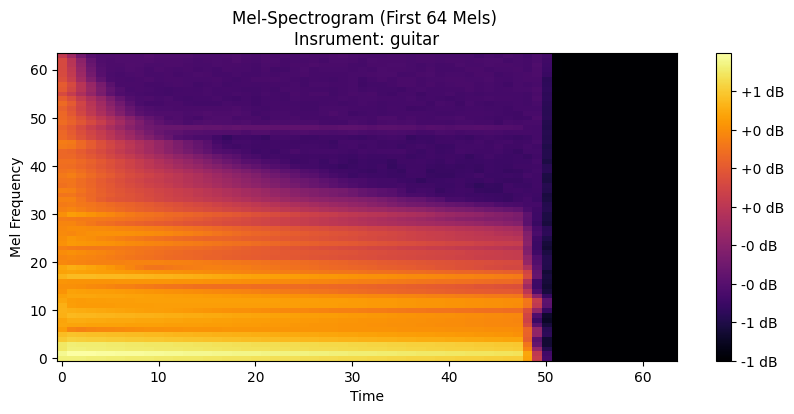

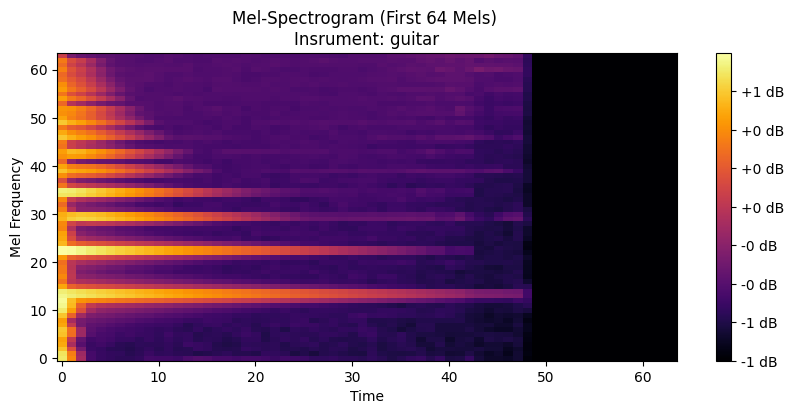

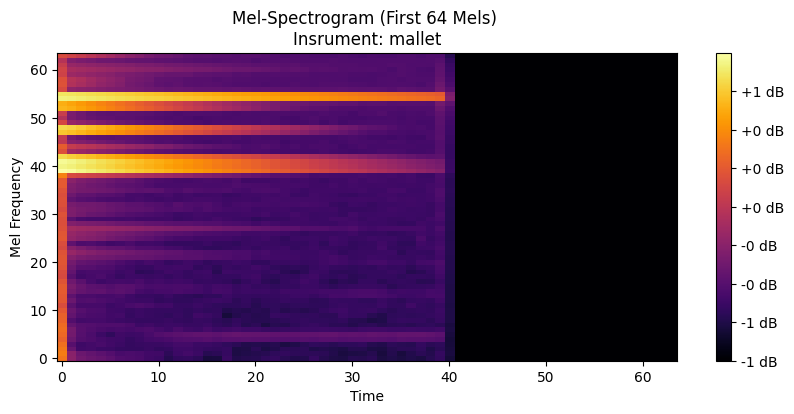

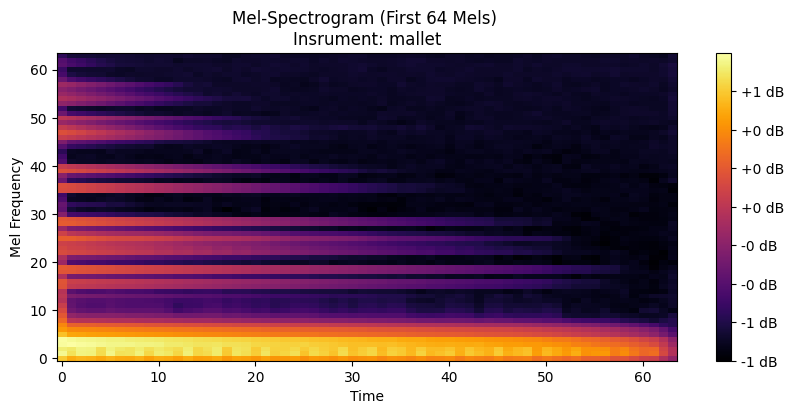

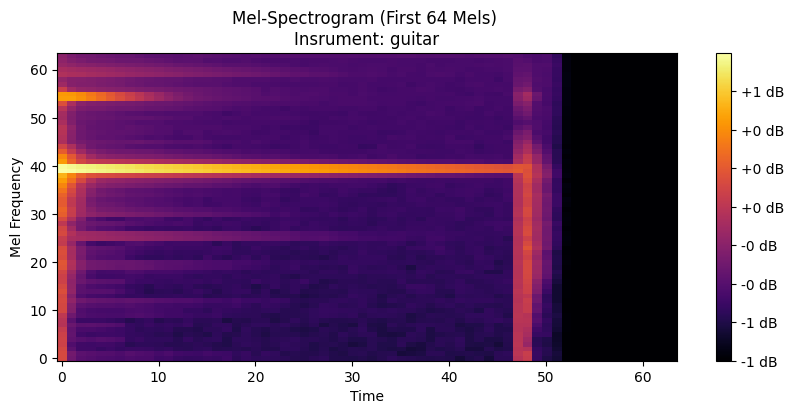

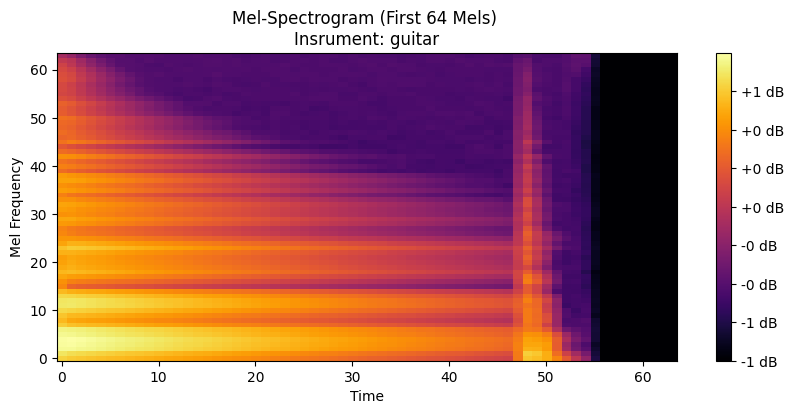

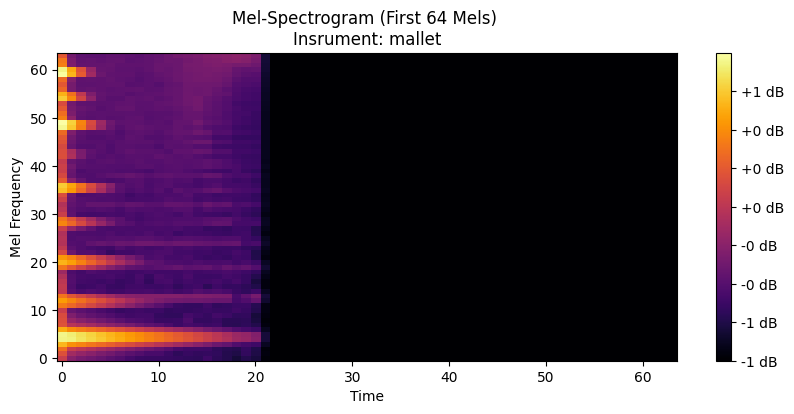

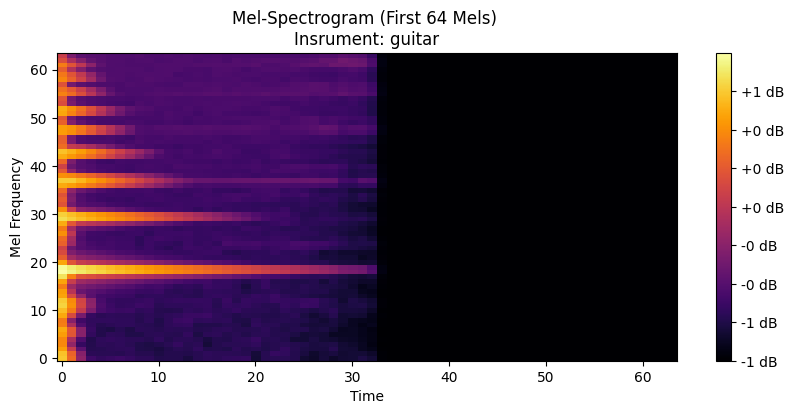

In [11]:
from matplotlib import image
# 4. Plot
import matplotlib.pyplot as plt

images, labels = next(iter(dataloader))

for i in range(len(images)):
  image = images[i].squeeze(0) # Squeeze the image to remove the channel dimension
  label = labels[i].item()
  int_to_name = {v: k for k, v in dataset.label_map.items()}
  name = int_to_name.get(label, "Unknown")


  plt.figure(figsize=(10, 4))
  plt.imshow(image.numpy(), origin='lower', aspect='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f"Mel-Spectrogram (First 64 Mels) \nInsrument: {name}")
  plt.xlabel('Time')
  plt.ylabel('Mel Frequency')
  plt.show()